# Exploration_SSAC 13 주식 시계열 데이터를 활용하여 주식 예측

* Keywords : 시계열 데이터, Stationary(안정성) Time Series Data, ARIMA Model, Time series decomposition(시계열 분해)     
* Math Concept : 분산, 공분산, 상관계수, 귀무가설, 대립가설, p-value    

#### 안정적이지 않은 시계열 데이터 분석 방법    
* 정성적인 분석을 통해 보다 안정적(Stationary)인 특성을 가지도록 기존의 시계열 데이터 가공/변형    
    * 로그함수 변환     
    * Moving Average제거 - 추세(Trend) 상쇄    
    * 차분(Differencing) - 계절성(Seasonality) 상쇄    
* 시계열 분해 기법을 적용    

#### ARIMA Model (AutoRegressive Integrated Moving Average)      
시계열 분해 기법을 통해 Trend, Seasonality, Residual로 분해하여 안정적인 시계열 데이터로 변환 가능한데, 이러한 원리를 기반으로 시계열 데이터 예측 모델을 자동으로 만들어 주는 모델   
* AR (AutoRegressive) : 자기 회귀, 이전 p개의 데이터가 가중합으로 수렴한다고 보는 모델    
* I (Interation) : 차분누적, 이전 데이터와 d차 차분의 누적 합이라고 보는 모델
* MA (Moving Average) : 이동 평균, 이전 p개의 예측오차값의 가중합으로 수렴한다고 보는 모델

#### Process of Project       
1) 시계열 데이터 준비     
2) 시계열 데이터 전처리     
3) 시계열 안정성 분석     
4) 모델 학습, 테스트 데이터셋 생성     
5) 적정 ARIMA 모수 찾기 (p, q, d)    
6) ARIMA 모델 훈련/테스트     
7) 다른 주식 종목 예측 (1~6 step 반복)

#### 필요한 모듈 import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose # 정량적 데이터 분해

## 1) 데이터 로드

In [3]:
pd.read_csv(dataset_filepath)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-24,57400.0,58100.0,56800.0,56800.0,54300.218750,25627537
1,2020-02-25,56200.0,58000.0,56200.0,57900.0,55351.808594,23885408
2,2020-02-26,56000.0,57000.0,56000.0,56500.0,54013.425781,25483102
3,2020-02-27,56300.0,56900.0,55500.0,55900.0,53439.832031,23209541
4,2020-02-28,55000.0,55500.0,54200.0,54200.0,51814.648438,30054227
...,...,...,...,...,...,...,...
243,2021-02-17,83900.0,84200.0,83000.0,83200.0,83200.000000,18307735
244,2021-02-18,83200.0,83600.0,82100.0,82100.0,82100.000000,21327683
245,2021-02-19,82300.0,82800.0,81000.0,82600.0,82600.000000,25880879
246,2021-02-22,83800.0,84200.0,82200.0,82200.0,82200.000000,25419886


* 예측을 위한 데이터로 Close 컬럼 데이터만 사용

In [4]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-02-24    56800.0
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
Name: Close, dtype: float64

## 2) 데이터 전처리      
* 결측치 처리    
* 로그 변환     
* 데이터 분석

In [5]:
pd.DataFrame(ts)

,Close
Date,
2020-02-24,56800.0
2020-02-25,57900.0
2020-02-26,56500.0
2020-02-27,55900.0
2020-02-28,54200.0
...,...
2021-02-17,83200.0
2021-02-18,82100.0
2021-02-19,82600.0


* 결측치 유무 확인

In [26]:
?ts.interpolate
'''
Fill NaN values using an interpolation method.

ts.interpolate(
    method: 'str' = 'linear',
    axis: 'Axis' = 0,
    limit: 'Optional[int]' = None,
    inplace: 'bool_t' = False,
    limit_direction: 'Optional[str]' = None,
    limit_area: 'Optional[str]' = None,
    downcast: 'Optional[str]' = None,
    **kwargs,
) -> 'Optional[FrameOrSeries]'

 * 'time': Works on daily and higher resolution data to interpolate
      given length of interval.
'''

In [7]:
ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

* 로그 변환

In [8]:
ts_log = np.log(ts)
ts_log.head()

Date
2020-02-24    10.947292
2020-02-25    10.966473
2020-02-26    10.941996
2020-02-27    10.931320
2020-02-28    10.900436
Name: Close, dtype: float64

In [9]:
pd.DataFrame(ts_log)

,Close
Date,
2020-02-24,10.947292
2020-02-25,10.966473
2020-02-26,10.941996
2020-02-27,10.931320
2020-02-28,10.900436
...,...
2021-02-17,11.329003
2021-02-18,11.315693
2021-02-19,11.321765


In [11]:
print(ts_log.min())
print(ts_log.max())

10.657259354912508
11.418614785498987


## 3) 시계열 안정성 분석    
* 정성적 그래프 분석   
* 정량적 Augmented Dicky-Fuller Test    
* 시계열 분해 (Time Series Decomposition)    
* Residual 안정성 확인

In [10]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

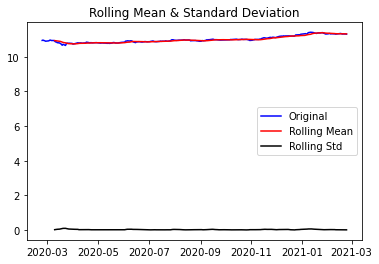

Results of Dickey-Fuller Test:
Test Statistic                  -0.133179
p-value                          0.946032
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


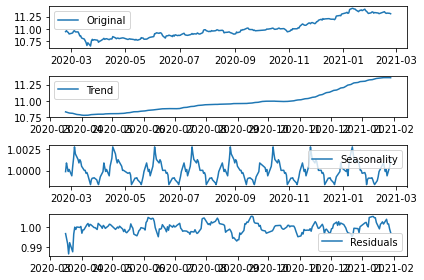

In [18]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12) # window 12로 지정

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [19]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.900824e+00
p-value                        2.780778e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


## 4) 모델 학습, 테스트 데이터셋 생성

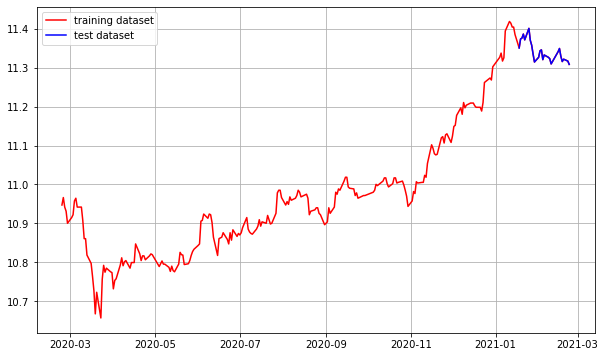

In [20]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5) 적정 ARIMA 모수 찾기 (p, q, d)     
* ACF, PACF 그려보기 -> p, q 구하기     
* 차분 안정석 확인 -> d 구하기

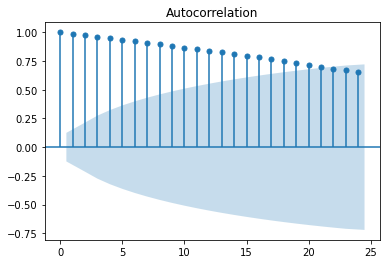

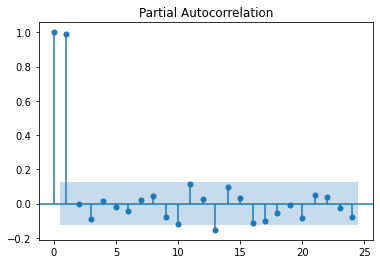

In [21]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.603116e+01
p-value                        6.055074e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


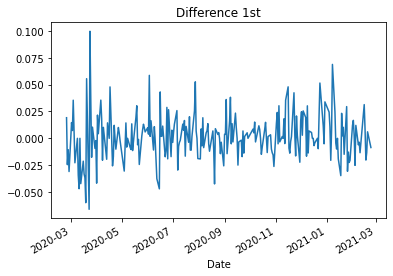

In [22]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

## 6) ARIMA 모델 훈련과 테스트     
* ARIMA 모델 빌드와 훈련    
* 모델 테스트 및 플로팅    
* 최종 예측 모델 정확도 측정(MAPE)

In [23]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 537.526
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 23 Feb 2021   AIC                          -1069.052
Time:                        17:05:13   BIC                          -1058.844
Sample:                             1   HQIC                         -1064.930
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.397      0.162      -0.001       0.005
ar.L1.D.Close    -0.0215      0.067     -0.321      0.748      -0.153       0.110
                                    Root

/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

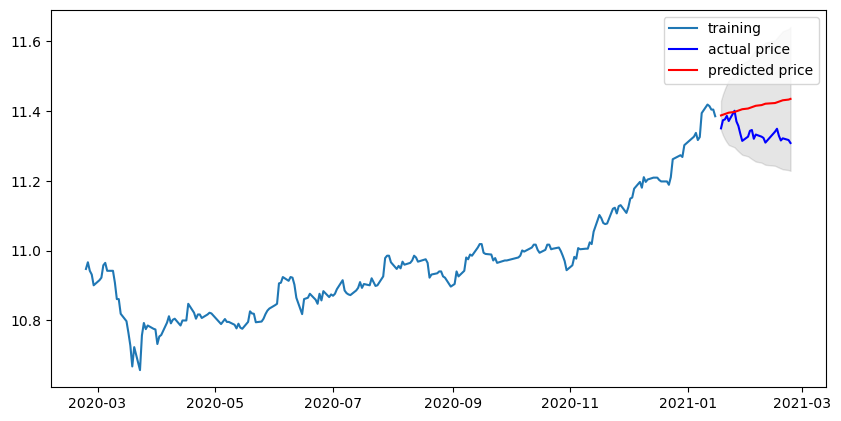

In [24]:
# Forecast : 결과가 fc에 담깁니다. 
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  46819561.12375839
MAE:  6060.034938311394
RMSE:  6842.48208793844
MAPE: 7.28%


## 7) 다른 주식 종목 예측     
* tesla 

In [3]:
# Time Series 생성
tsla_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(tsla_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-02-26    155.759995
2020-02-27    135.800003
2020-02-28    133.598007
2020-03-02    148.723999
2020-03-03    149.102005
Name: Close, dtype: float64

In [6]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-26,156.500000,162.662003,155.222000,155.759995,155.759995,70427500
2020-02-27,146.000000,147.953995,133.800003,135.800003,135.800003,121386000
2020-02-28,125.940002,138.104004,122.304001,133.598007,133.598007,122821000
2020-03-02,142.251999,148.738007,137.334000,148.723999,148.723999,100975000
2020-03-03,161.000000,161.395996,143.222000,149.102005,149.102005,128920000
...,...,...,...,...,...,...
2021-02-22,762.640015,768.500000,710.200012,714.500000,714.500000,37011700
2021-02-23,662.130005,713.609985,619.000000,698.840027,698.840027,66397000
2021-02-24,711.849976,745.000000,694.169983,742.020020,742.020020,36677100


In [7]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [8]:
# 로그 변환
ts_log = np.log(ts)
ts_log.head()

Date
2020-02-26    5.048316
2020-02-27    4.911183
2020-02-28    4.894835
2020-03-02    5.002092
2020-03-03    5.004631
Name: Close, dtype: float64

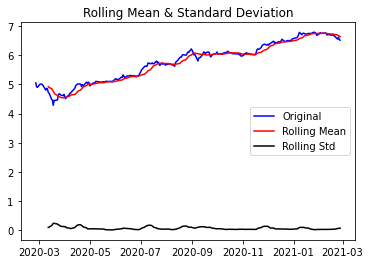

Results of Dickey-Fuller Test:
Test Statistic                  -0.689894
p-value                          0.849350
#Lags Used                       6.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


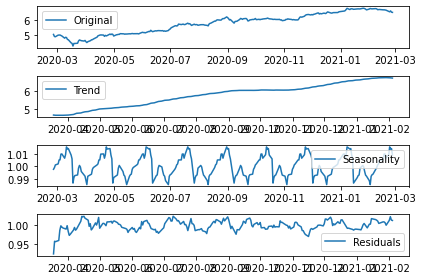

In [12]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [13]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.356356e+00
p-value                        2.537145e-08
#Lags Used                     3.000000e+00
Number of Observations Used    2.200000e+02
Critical Value (1%)           -3.460428e+00
Critical Value (5%)           -2.874769e+00
Critical Value (10%)          -2.573821e+00
dtype: float64


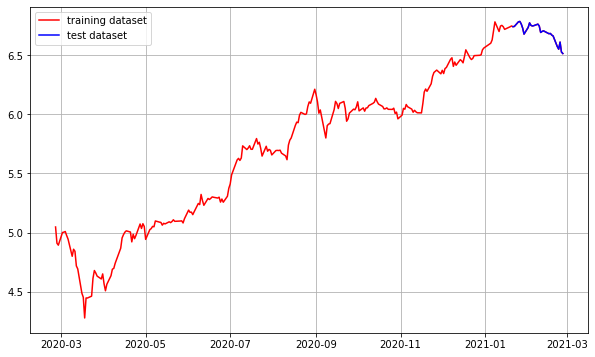

In [14]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

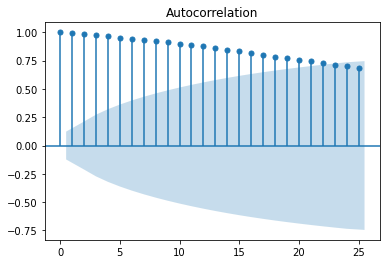

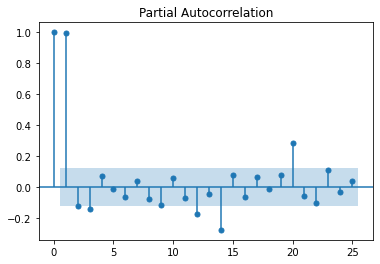

In [15]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.028550e+00
p-value                        6.271742e-10
#Lags Used                     5.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


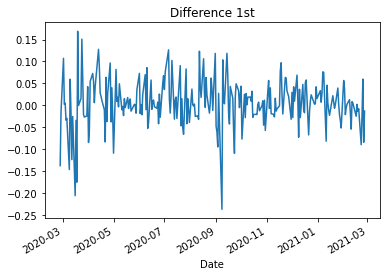

In [16]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [17]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary()) 

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 336.021
Method:                       css-mle   S.D. of innovations              0.055
Date:                Sat, 27 Feb 2021   AIC                           -666.041
Time:                        00:45:28   BIC                           -655.767
Sample:                             1   HQIC                          -661.895
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0075      0.004      2.099      0.036       0.000       0.014
ar.L1.D.Close    -0.0242      0.067     -0.359      0.719      -0.156       0.108
                                    Root

/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

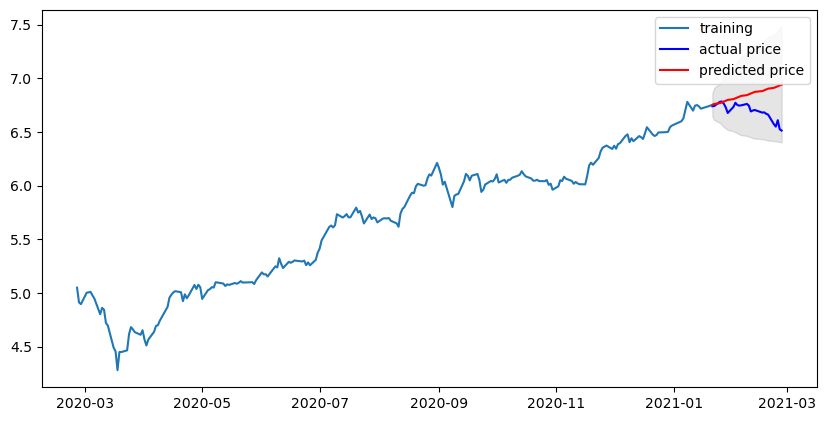

In [18]:
# Forecast : 결과가 fc에 담깁니다. 
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  29608.68489934755
MAE:  134.69377591948893
RMSE:  172.07174346576357
MAPE: 17.78%


* SKT 

In [20]:
# Time Series 생성
skt_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/SKT.csv'
df = pd.read_csv(skt_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-02-26    12.07
2020-02-27    11.97
2020-02-28    11.98
2020-03-02    12.29
2020-03-03    11.95
Name: Close, dtype: float64

In [21]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [22]:
# 로그 변환
ts_log = np.log(ts)
ts_log.head()

Date
2020-02-26    2.490723
2020-02-27    2.482404
2020-02-28    2.483239
2020-03-02    2.508786
2020-03-03    2.480731
Name: Close, dtype: float64

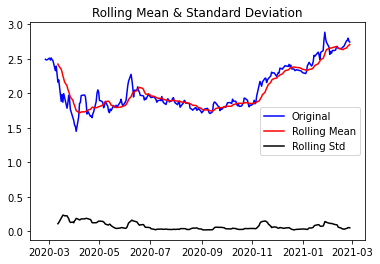

Results of Dickey-Fuller Test:
Test Statistic                  -0.816566
p-value                          0.814208
#Lags Used                       6.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


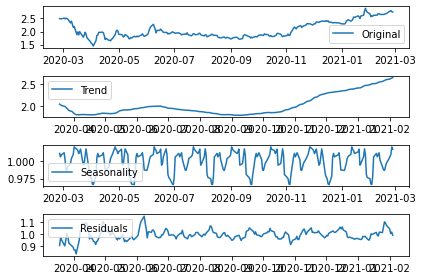

In [23]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [24]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.449997e+00
p-value                        1.531905e-08
#Lags Used                     2.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


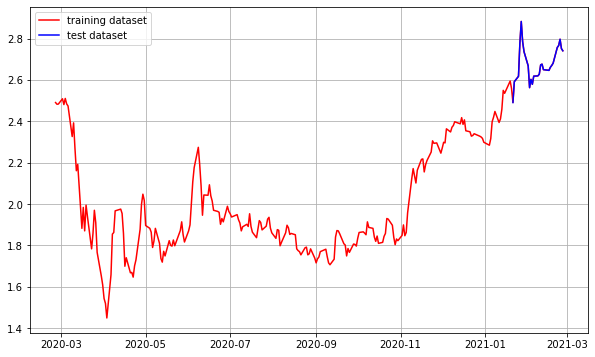

In [25]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

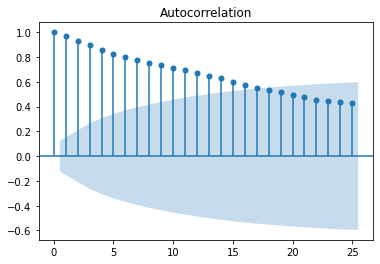

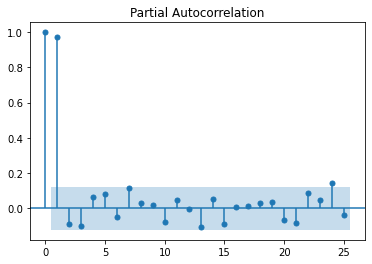

In [26]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -3.831301
p-value                          0.002603
#Lags Used                      15.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


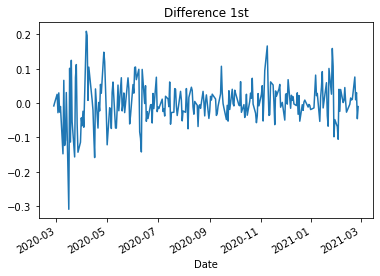

In [27]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [28]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 315.174
Method:                       css-mle   S.D. of innovations              0.060
Date:                Sat, 27 Feb 2021   AIC                           -624.348
Time:                        01:01:03   BIC                           -614.073
Sample:                             1   HQIC                          -620.202
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.004      0.063      0.950      -0.008       0.009
ar.L1.D.Close     0.0887      0.066      1.344      0.179      -0.041       0.218
                                    Root

/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

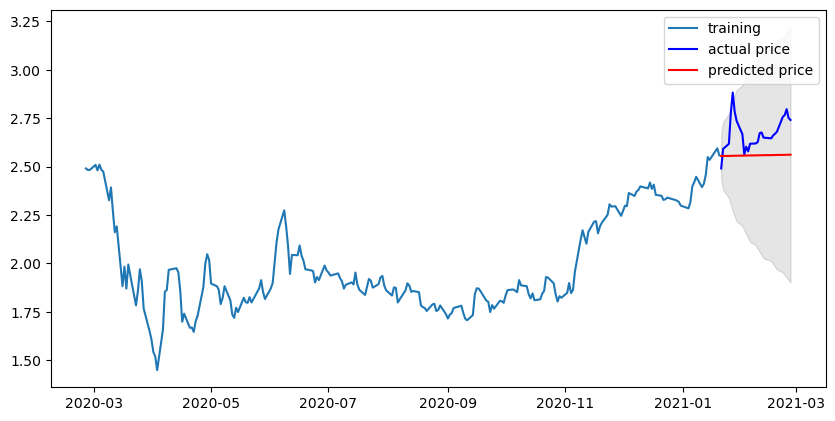

In [29]:
# Forecast : 결과가 fc에 담깁니다. 
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4.454987228899899
MAE:  1.7575085816929177
RMSE:  2.110684066576497
MAPE: 11.47%


## Results of Project    

이미지나 자연어처럼 패턴을 찾기가 쉽지 않은 시계열 데이터를 다루는 것이 쉽지 않았다. 그러한 점을 보완하기 위해 ARIMA 모델을 학습하였고, 수학적인 지식이 많이 연관되어 있는 모델이라 이해하기 쉽지 않았다.